# Gaussian Naive Bayes

In [2]:
# importing relevant packages and functions
%run /Users/thomasadler/Desktop/futuristic-platipus/capstone/notebooks/ta_01_packages_functions.py

/Users/thomasadler/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Preparing data

In [3]:
#clean dataset
modelling_df=pd.read_csv(data_filepath + 'master_modelling_df.csv', index_col=0)

#check
modelling_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107184 entries, 0 to 108905
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   lat_deg                   107184 non-null  float64
 1   lon_deg                   107184 non-null  float64
 2   is_functioning            107184 non-null  int64  
 3   distance_to_primary       107184 non-null  float64
 4   distance_to_secondary     107184 non-null  float64
 5   distance_to_tertiary      107184 non-null  float64
 6   distance_to_city          107184 non-null  float64
 7   distance_to_town          107184 non-null  float64
 8   usage_cap                 107184 non-null  float64
 9   is_complex_tech           107184 non-null  int64  
 10  is_installed_after_2006   107184 non-null  int64  
 11  is_public_management      107184 non-null  int64  
 12  crucialness               107184 non-null  float64
 13  perc_hh_head_male         107184 non-null  f

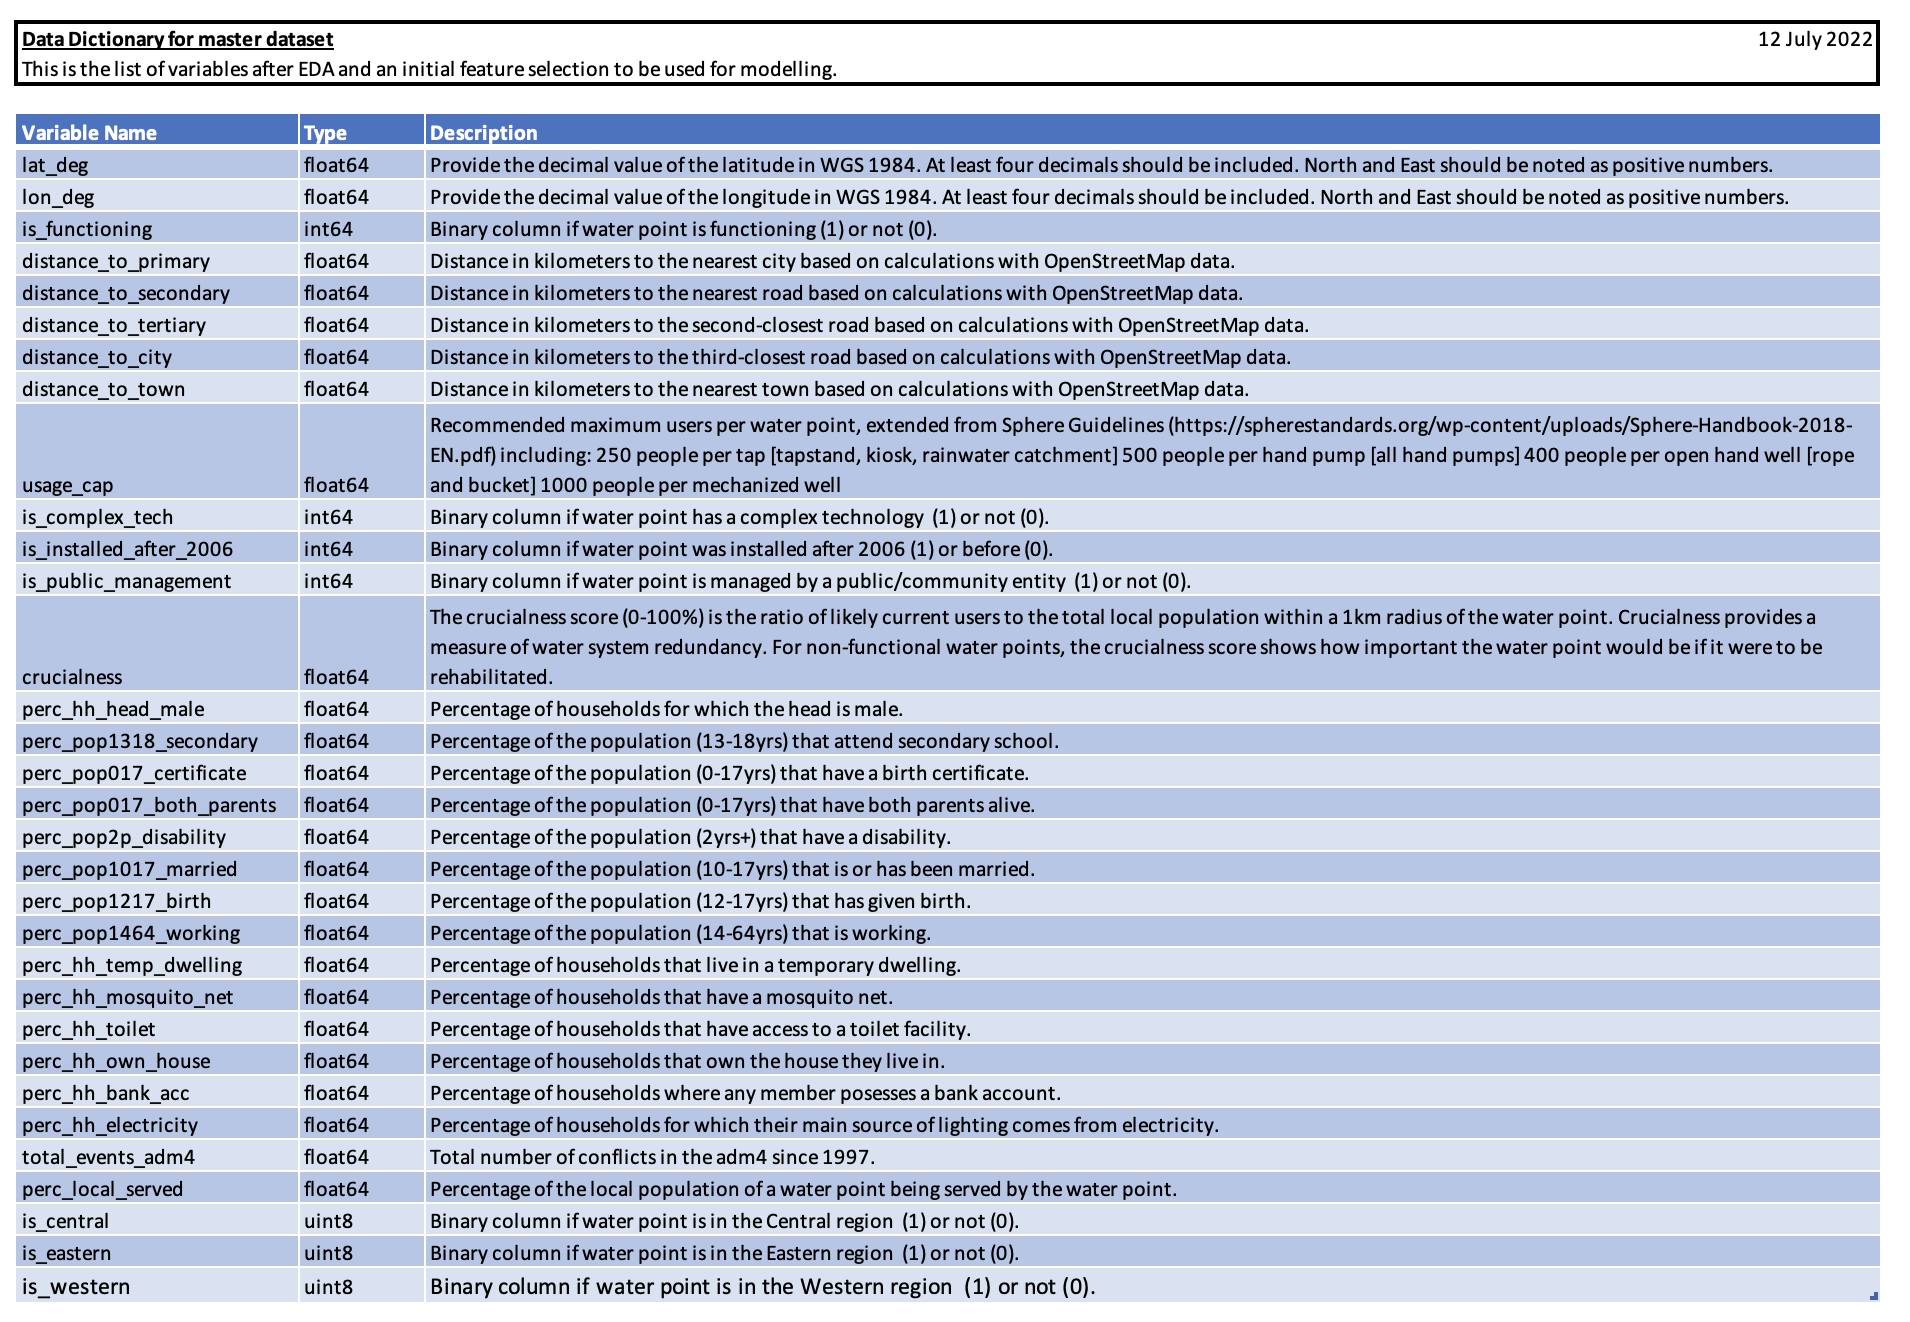

In [4]:
#data dictionary
Image(dictionary_filepath+"5-Modelling-Data-Dictionary.png")

In [5]:
# assigning X (independent) and y (dependent) variables
X =modelling_df.loc[:, modelling_df.columns != 'is_functioning']
y = modelling_df['is_functioning']

#check
print(X.shape)
print(y.shape)

(107184, 31)
(107184,)


Our independent variable (X) should have the same number of rows (107,184) than our dependent variable (y). y should only have one column as it is the outcome variable.

In [6]:
#split train test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_seed)

In [7]:
# #resampling dataset
sm = SMOTE(random_state=rand_seed)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

#compre resampled dataset
print(f"Test set has {round(y_test.value_counts(normalize=True)[0]*100,1)}% non-functioning water points and {round(y_test.value_counts(normalize=True)[1]*100,1)}% functioning")
print(f"Original train set has {round(y_train.value_counts(normalize=True)[0]*100,1)}% non-functioning water points and {round(y_train.value_counts(normalize=True)[1]*100,1)}% functioning")
print(f"Resampled train set has {round(y_train_res.value_counts(normalize=True)[0]*100,1)}% non-functioning water points and {round(y_train_res.value_counts(normalize=True)[1]*100,1)}% functioning")

Test set has 19.7% non-functioning water points and 80.3% functioning
Original train set has 19.5% non-functioning water points and 80.5% functioning
Resampled train set has 50.0% non-functioning water points and 50.0% functioning


We over-sample the minority class, non-functioning water points, to get an equal distribution of our outcome variable. Note this should be done on the train set and not the test set as we should not tinker with the latter.

Note that we do not scale our data because the estimator in a Gaussian Naive Bayes computes the mean and standard deviation of a feature, then assumes that this feature follows a Normal distribution. It then uses the distance of each observation from the mean of that distribution to calculate the conditional probability of that observation with that feature value to be in a certain class.

# Running baseline model

In [8]:
#time process
start=time.time()

#instantiate and fit
GNB_base = GaussianNB().fit(X_train_res, y_train_res)

end=time.time()

time_fit_base=end-start

print(f"Time to fit the model on the training set is {round(time_fit_base,3)} seconds")

Time to fit the model on the training set is 0.14 seconds


We use a Gaussian Naive Bayes as it can deal with our features being continuous variables.

ROC AUC: 0.6588822704010048
PR AUC: 0.6412104746168411
              precision    recall  f1-score   support

           0       0.63      0.54      0.58     68984
           1       0.60      0.68      0.64     68984

    accuracy                           0.61    137968
   macro avg       0.61      0.61      0.61    137968
weighted avg       0.61      0.61      0.61    137968



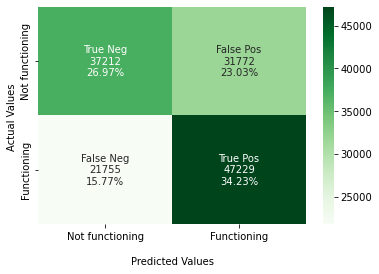

In [9]:
# get classification report for train 
fpr_train_base, tpr_train_base, roc_auc_train_base, precision_train_base_plot, recall_train_base_plot, pr_auc_train_base, time_predict_train_base = print_report(GNB_base, X_train_res, y_train_res)

#storing accuracy scores
accuracy_train_base, precision_train_base, recall_train_base, f1_train_base = get_scores(GNB_base, X_train_res, y_train_res)


Our training set has a relatively low accuracy metrics. It has an especially high number of False Positives. 

ROC AUC: 0.6154788215939245
PR AUC: 0.8574385395873867
              precision    recall  f1-score   support

           0       0.27      0.47      0.34      4221
           1       0.84      0.69      0.75     17216

    accuracy                           0.64     21437
   macro avg       0.55      0.58      0.55     21437
weighted avg       0.73      0.64      0.67     21437



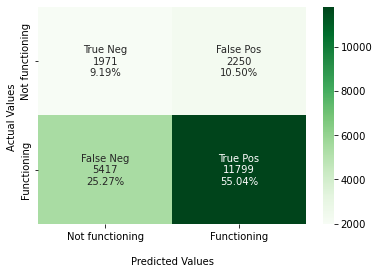

Time to predict the outcome variable for the test set is 0.028 seconds


In [10]:
# get classification report and confusion matrix for test
fpr_test_base, tpr_test_base, roc_auc_test_base, precision_test_base_plot, recall_test_base_plot, pr_auc_test_base, time_predict_test_base = print_report(GNB_base, X_test, y_test)

print(f"Time to predict the outcome variable for the test set is {round(time_predict_test_base,3)} seconds")

#storing accuracy scores
accuracy_test_base, precision_test_base, recall_test_base, f1_test_base = get_scores(GNB_base, X_test, y_test)

Suprisingly our test set has a better accuracy score of 64%. However, it achieves this by having a very low precision score for non-functioning points. It mislabelled a lot of functioning points as non-functioning.

# Finding optimal hyperparameters

We run a grid search cross validation through a pipeline to find the optimal hyperparameters. The grid search looks at every combination of hyperparameters to find the one with the best cross-validation score.

In [11]:
#setting hyparameter loop

# setting up which models/scalers we want to grid search
estimator = [('reduce_dim', PCA()),
('GNB', GaussianNB())]

# defining distribution of parameters we want to compare
param = {'reduce_dim__n_components': [0.5, 0.6, 0.7, 0.8, 0.9, None]}

# run cross validation
pipeline_cross_val_grid(estimator, param, X_train_res, y_train_res, X_test, y_test)

The model with the best CV score has the following parameters: {'reduce_dim': None}.
The best model has an accuracy score of 0.6423473433782713 on the test set


We only test dimensionality reduction using PCA, and the best model is where we do not apply it. As a result, we do not have an optimised model to compare with, as the baseline was already the best we could find.

# Comparing results

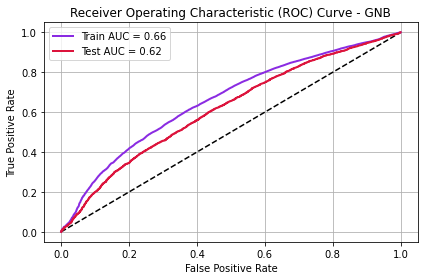

In [12]:
#compare ROCs on train and test

plt.plot(figsize=(10,15))
plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve - GNB')
plt.plot(fpr_train_base, tpr_train_base, color='blueviolet', lw=2,
    label='Train AUC = %0.2f' % roc_auc_train_base)
plt.plot(fpr_test_base, tpr_test_base, color='crimson', lw=2,
    label='Test AUC = %0.2f' % roc_auc_test_base)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="best")
plt.tight_layout()
plt.grid()

Overall, although the test has a better accuracy score than the train set, it has a lower AUC. This is because when we look at various thresholds, the training set still performs better on the whole. It seems that the test set performed especially well for the specific threshold level we looked at.

# Visualising feature importance

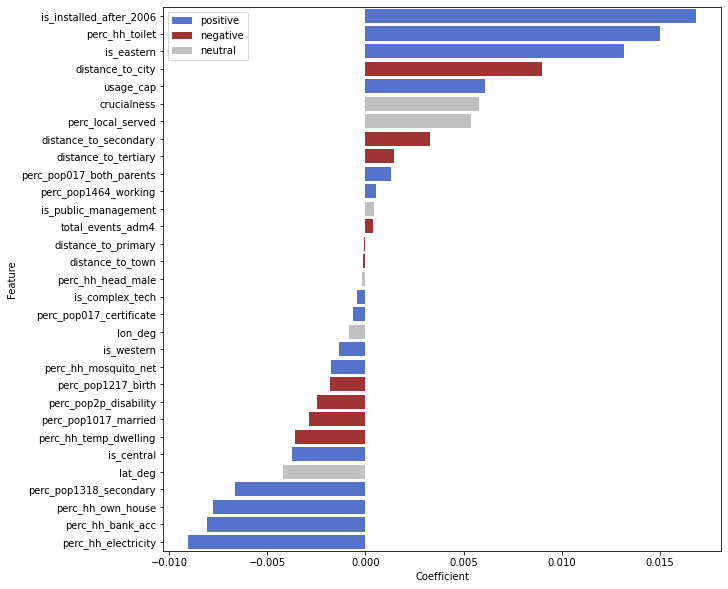

In [13]:
#getting feature importance
imps = permutation_importance(GNB_base, X_test, y_test)

#visualising coefficient importance
coeff_bar_chart(imps.importances_mean, X.columns, t=False)

We see that water points which are installed after 2006 and those that are in regions with a high rate of access to toilets increases the probability of that water point functioning.

It is peculiar, however, that high rates of electricity access, bank account ownership and house ownership are associated with a water point not functioning. This may show the limitation of naive bayes in taking into many other features at the same time to identify patterns in the data.

Similarly to previous models the number of conflicts/violent events are not very important in our model.

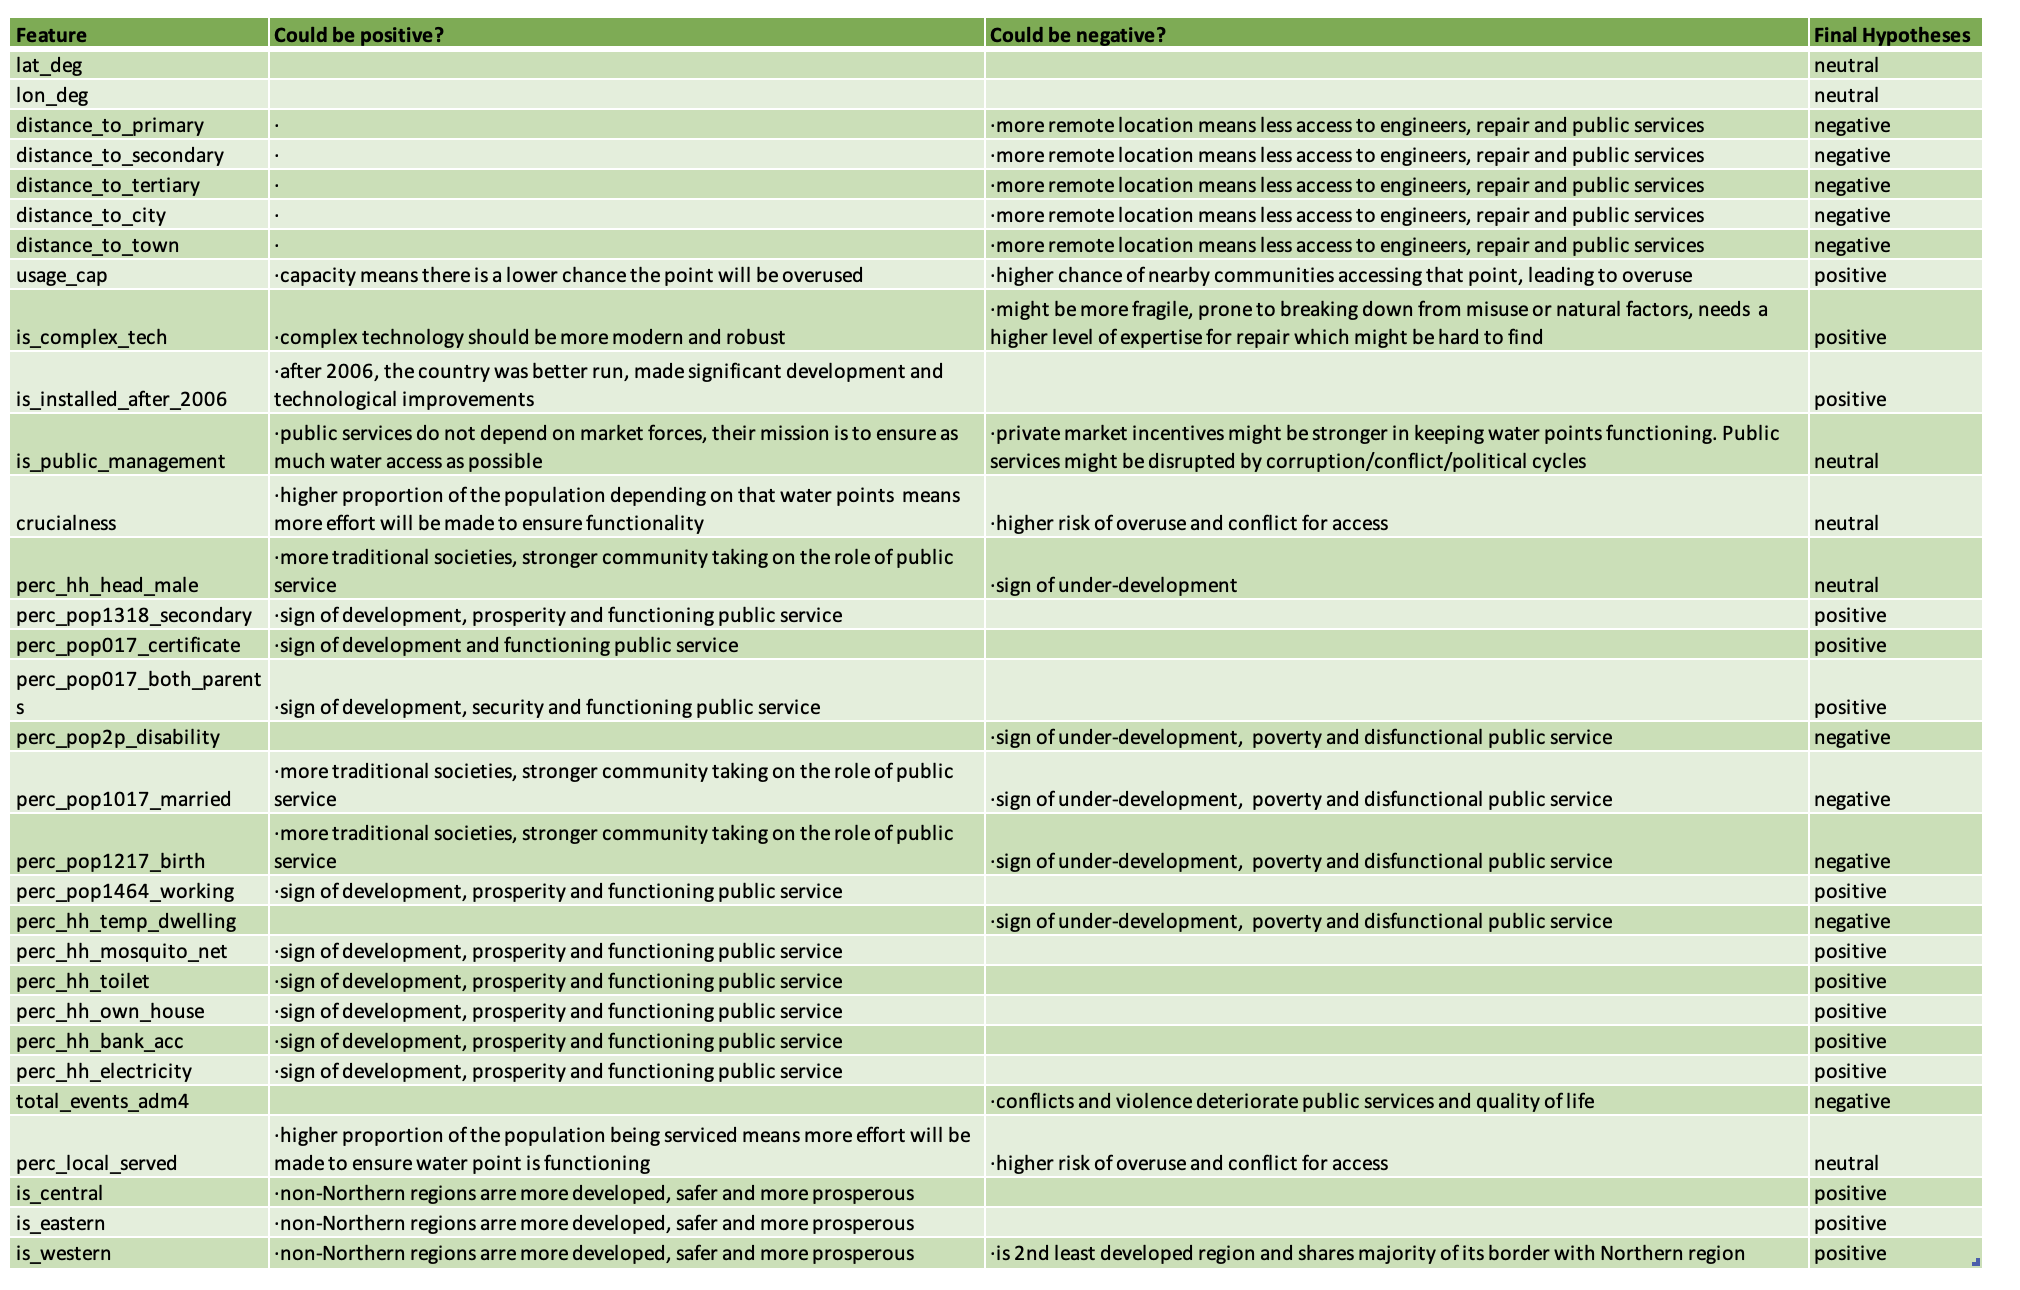

In [14]:
#hypotheses table
Image(dictionary_filepath+"6-Hypotheses.png")

# Exporting

In [15]:
#export model results
joblib.dump(GNB_base, model_filepath+'gaussian_naive_bayes_model.sav')

['/Users/thomasadler/Desktop/futuristic-platipus/models/gaussian_naive_bayes_model.sav']

In [16]:
#export best model in dataframe
d = {'Model':['Gaussian Naive Bayes'], 'Parameters':[''],   'Accuracy Train': [accuracy_train_base],\
    'Precision Train': [precision_train_base], 'Recall Train': [recall_train_base], 'F1 Train': [f1_train_base], 'ROC AUC Train':[roc_auc_train_base],\
        'Accuracy Test': accuracy_test_base, 'Precision Test': [precision_test_base], 'Recall Test': [recall_test_base], 'F1 Test': [f1_test_base],\
            'ROC AUC Test':[roc_auc_test_base],'Time Fit': time_fit_base,\
                'Time Predict': time_predict_test_base,  "Precision Non-functioning Test":0.27, "Recall Non-functioning Test":0.47,\
                                "F1 Non-functioning Test":0.34, "Precision Functioning Test":0.84, "Recall Functioning Test":0.69,"F1 Functioning Test":0.75}

#to dataframe
best_model_result_df=pd.DataFrame(data=d)

#check
best_model_result_df

,Model,Parameters,Accuracy Train,Precision Train,Recall Train,F1 Train,ROC AUC Train,Accuracy Test,Precision Test,Recall Test,F1 Test,ROC AUC Test,Time Fit,Time Predict,Precision Non-functioning Test,Recall Non-functioning Test,F1 Non-functioning Test,Precision Functioning Test,Recall Functioning Test,F1 Functioning Test
0,Gaussian Naive Bayes,,0.612033,0.614446,0.612033,0.609977,0.658882,0.642347,0.727009,0.642347,0.673018,0.615479,0.140393,0.028196,0.27,0.47,0.34,0.84,0.69,0.75


In [17]:
#export new dataset
best_model_result_df.to_csv(model_filepath + 'gaussian_naive_bayes_model.csv')

In [18]:
#list of metrics we want to visualise
metrics=[fpr_train_base, tpr_train_base, fpr_test_base, tpr_test_base]
metrics_name=['fpr_train_base', 'tpr_train_base', 'fpr_test_base', 'tpr_test_base']

#save numpy arrays for model comparison
for metric, metric_name in zip(metrics, metrics_name):
    np.save(model_filepath+f'gaussian_naive_bayes_{metric_name}', metric)